In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
res_dir = r'U:\Scientific Data\RG-AS04-Data01\Yinan\sc_data'
fig_dir = r'U:\Scientific Data\RG-AS04-Data01\Yinan\sc_data\Presentation'
stage_id = '50p'
prefix = 'A'
raw_dir = {'E1': r'U:\Scientific Data\RG-AS04-Data01\Yinan\23-08-29\Result', 'E2': r'U:\Scientific Data\RG-AS04-Data01\Yinan\23-07-28\Result\newpipeline'}
rotation = {'E1': 0, 'E2': -140}
#rotation = {'E1': 7, 'E2': -119}

In [2]:
def rot_dots(X, rot):
    theta = np.radians(rot)
    X2d = X[:, 1:3]
    [cx, cy] = np.mean(X2d, axis=0)
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                [np.sin(theta), np.cos(theta)]])
    X2d_rot = np.dot(X2d - np.array([cx, cy]), rotation_matrix.T) + np.array([cx, cy]) 
    X_rot = X.copy()
    X_rot[:, 1:3] = X2d_rot
    return(X_rot)

def convert_to_scdata(res_dir, stage_id, eid, rotation, prefix):
    ctdata = pd.read_csv(res_dir + os.sep + 'sc_data_' + stage_id + '.csv', index_col=0)
    nucdata = pd.read_csv(res_dir + os.sep + 'nuc_data_' + stage_id + '.csv', index_col=0)
    celldata = pd.read_csv(res_dir + os.sep + 'celldata_' + stage_id + '.csv', index_col=0)
    
    blank_ct = ctdata['_blank']
    ctdata = ctdata.drop(['_blank'], axis=1)
    nucdata = nucdata.drop(['_blank'], axis=1)
    
    scdata = sc.AnnData(ctdata)
    celldata_ = celldata.loc[ctdata.index]
    scdata.obs["global_z"] = np.array(celldata_["global_z"])
    scdata.obs["global_x"] = np.array(celldata_["global_x"])
    scdata.obs["global_y"] = np.array(celldata_["global_y"])
    scdata.obs["cellvol"] = np.array(celldata_["cellvol"])
    scdata.obs['stage'] = prefix + '_' + stage_id
    scdata.obs['batch'] = eid
    scdata.obs['cell_id'] = ctdata.index
    scdata.obs['blank_ct'] = np.array(blank_ct)
    scdata.obsm['X_ct'] = scdata.X.copy()

    Xcms = np.array(scdata.obs[['global_z', 'global_x', 'global_y']])
    Xcms[:, 1:] *= 0.108
    Xcms[:, 0] *= 0.3
    Xcms = rot_dots(Xcms, rotation[eid])
    Xcms[:, 2] = -Xcms[:, 2] 

    scdata.obsm['spatial'] = Xcms[:, [1, 2, 0]]
    
    scdata.layers['spliced'] = np.array(ctdata.loc[scdata.obs_names.astype(float)]- nucdata.loc[scdata.obs_names.astype(float)])
    scdata.layers['unspliced'] = np.array(nucdata.loc[scdata.obs_names.astype(float)])
    
    scdata.obs_names = eid + '_' + scdata.obs_names
    return scdata

In [3]:
scdata_E1 = convert_to_scdata(raw_dir['E1'], stage_id, 'E1', rotation, prefix=prefix)
scdata_E2 = convert_to_scdata(raw_dir['E2'], stage_id, 'E2', rotation, prefix=prefix)

C:\Users\wan0000\AppData\Roaming\Python\Python39\site-packages\anndata\_core\anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\wan0000\AppData\Roaming\Python\Python39\site-packages\anndata\_core\anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
def filter_bad_cells(scdata, blank_thres, whis=4):
    import matplotlib.pyplot as plt
    ratio = np.sum(scdata.X, axis=1)/scdata.obs['cellvol']
    q1 = np.percentile(ratio, 25)
    q3 = np.percentile(ratio, 75)
    outlier = (ratio<q1-whis*(q3-q1)) | (ratio>q3+whis*(q3-q1))
    
    plt.scatter(np.sum(scdata.X, axis=1), scdata.obs['cellvol'], 5, c=outlier, cmap='seismic') # 'c' specifies the colors, 'cmap' is the colormap
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('total count')
    plt.ylabel('cell volumne')
    
    ct_cutoff = [blank_thres, np.Inf]
    plt.vlines(ct_cutoff, plt.ylim()[0],  plt.ylim()[1], color='k')

    scdata = scdata[~outlier]
    sc.pp.filter_cells(scdata, min_counts=ct_cutoff[0])
    sc.pp.filter_cells(scdata, max_counts=ct_cutoff[1])
    #plt.xlim(ct_cutoff)
    return scdata

C:\Users\wan0000\AppData\Roaming\Python\Python39\site-packages\scanpy\preprocessing\_simple.py:137: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_counts'] = number


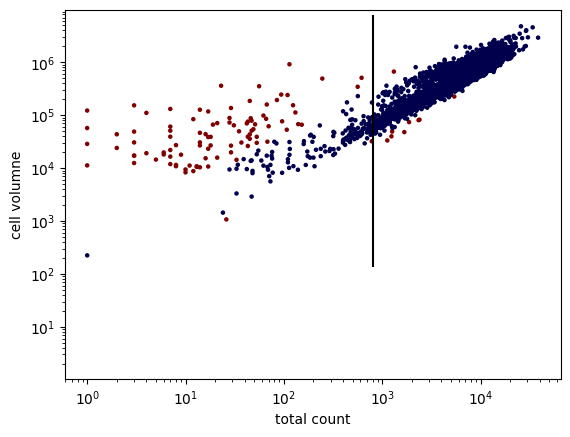

In [5]:
scdata_E1 = filter_bad_cells(scdata_E1, 800)

C:\Users\wan0000\AppData\Roaming\Python\Python39\site-packages\scanpy\preprocessing\_simple.py:137: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_counts'] = number


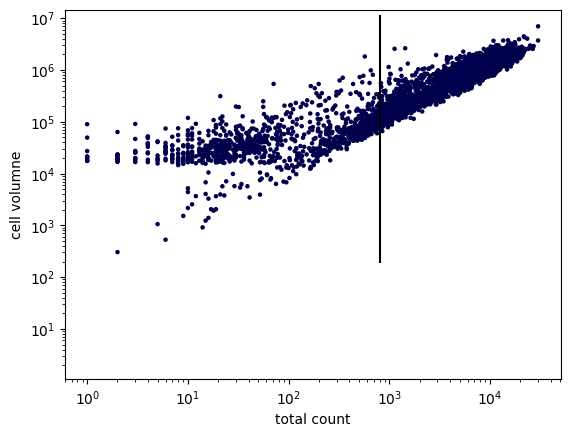

In [6]:
scdata_E2 = filter_bad_cells(scdata_E2, 800)

In [7]:
def visualize_leiden_napari(scdata):
    cms = scdata.obsm['spatial'][:, [2, 0, 1]]
    clusters = scdata.obs['leiden'].cat.categories
    cmap = ['m', 'b', 'r', 'y', 'g', 'c', 'w']
    import napari
    viewer = napari.Viewer()
    for icl, cl in enumerate(clusters):
        kp_cl = scdata.obs['leiden']==cl
        viewer.add_points(cms[kp_cl], size=5, face_color=cmap[icl % len(cmap)], name='cluster '+cl)
    return viewer

In [8]:
scdata_E2.obsm['spatial'][: , 1] += np.median(scdata_E1.obsm['spatial'][:, 1]) - np.median(scdata_E2.obsm['spatial'][:, 1])
scdata_E2.obsm['spatial'][: , 0] += np.max(scdata_E1.obsm['spatial'][:, 0]) - np.min(scdata_E1.obsm['spatial'][:, 0]) + 200

In [9]:
sc.pp.filter_cells(scdata_E1, min_genes=5)
volume = np.array(scdata_E1.obs['cellvol'])
scdata_E1.X = scdata_E1.obsm['X_ct']/volume[:,np.newaxis]*np.median(volume)
scdata_E1.obsm["X_raw"] = scdata_E1.X.copy()

In [10]:
sc.pp.filter_cells(scdata_E2, min_genes=5)
volume = np.array(scdata_E2.obs['cellvol'])
scdata_E2.X = scdata_E2.obsm['X_ct']/volume[:,np.newaxis]*np.median(volume)
scdata_E2.obsm["X_raw"] = scdata_E2.X.copy()

In [11]:
sc.pp.calculate_qc_metrics(scdata_E1, percent_top=None, inplace=True)
sc.pp.normalize_total(scdata_E1)
sc.pp.log1p(scdata_E1)
sc.pp.scale(scdata_E1)

In [12]:
nn = 10
sc.pp.neighbors(scdata_E1, n_neighbors=nn, use_rep = "X")#, n_pcs=50)
sc.tl.umap(scdata_E1,random_state=9)

C:\Users\wan0000\AppData\Roaming\Python\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\wan0000\AppData\Roaming\Python\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\wan0000\AppData\Roaming\Python\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\wan0000\AppData\Roaming\Python\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cma

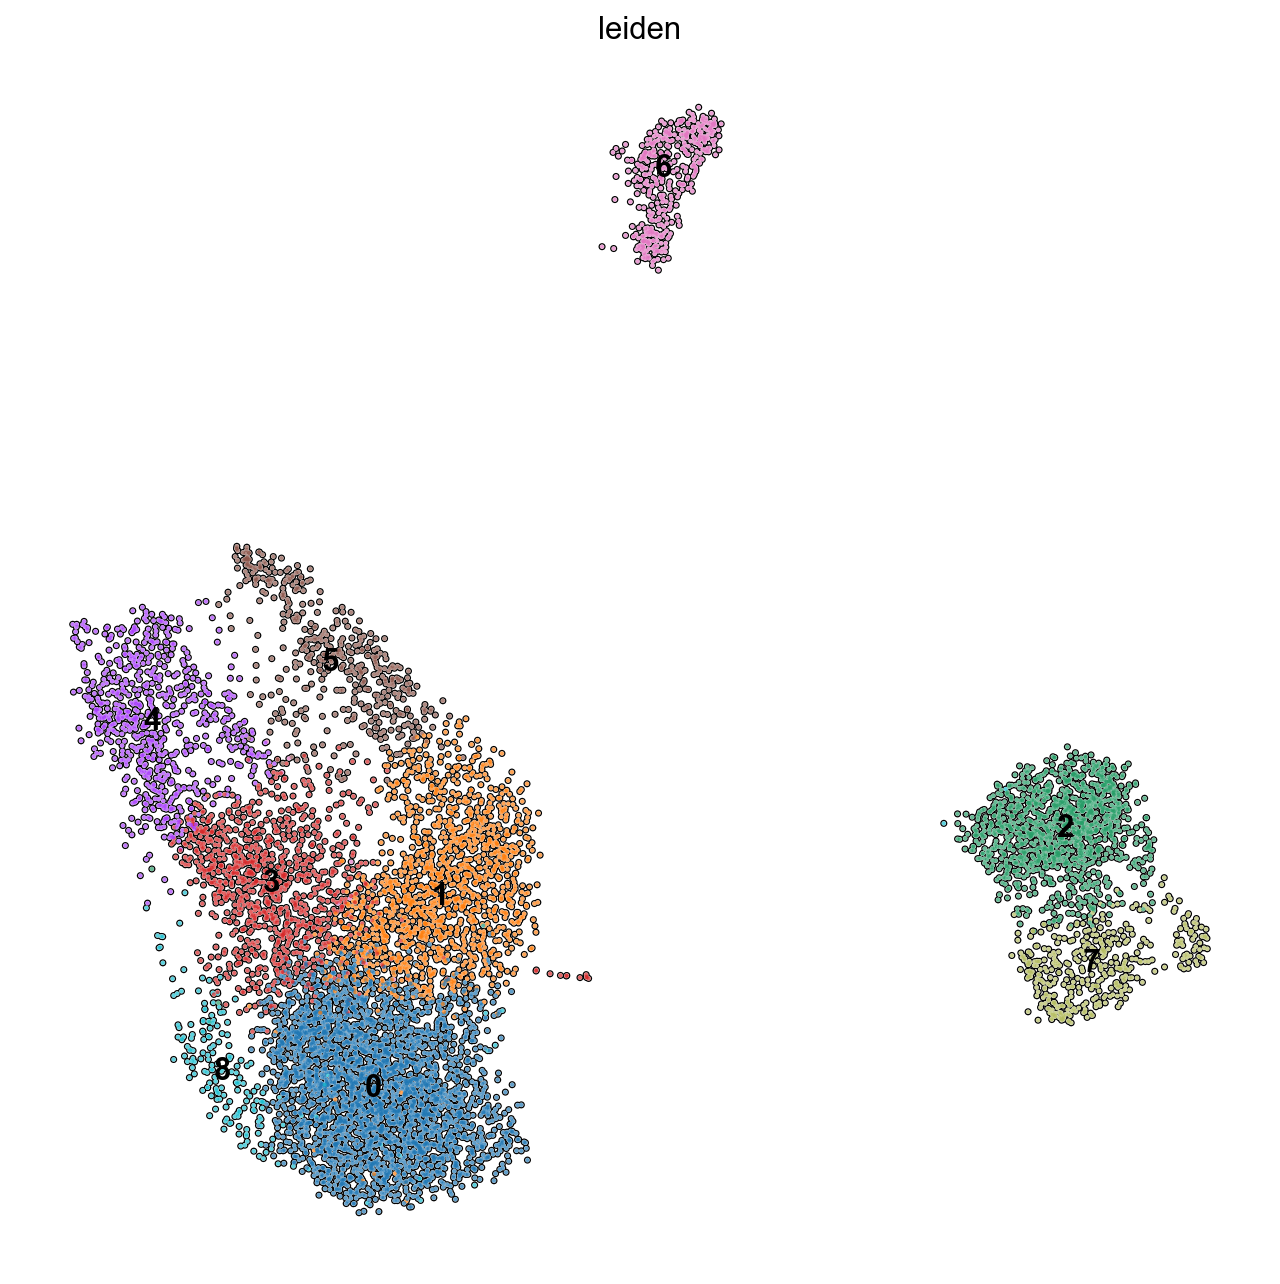

In [17]:
leiden_res = 1
sc.tl.leiden(scdata_E1, resolution=leiden_res) 
import matplotlib.pyplot as plt
plt.style.use('default')
sc.set_figure_params(figsize=(10,10))
sc.pl.umap(
    scdata_E1,
    color=['leiden'],
    add_outline=True,
    frameon=False,
    legend_loc='on data',
)

In [13]:
viewer = visualize_leiden_napari(scdata_E1)

E:\Anaconda3\envs\scanpy_env\lib\site-packages\numpy\core\numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
E:\Anaconda3\envs\scanpy_env\lib\site-packages\numpy\core\numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
E:\Anaconda3\envs\scanpy_env\lib\site-packages\numpy\core\numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
E:\Anaconda3\envs\scanpy_env\lib\site-packages\numpy\core\numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
E:\Anaconda3\envs\scanpy_env\lib\site-pa

In [18]:
scdata_E1.X = scdata_E1.obsm['X_raw'].copy()
scdata_E2.X = scdata_E2.obsm['X_raw'].copy()
sc.tl.pca(scdata_E1)
sc.tl.pca(scdata_E2)
sc.tl.ingest(scdata_E2, scdata_E1, obs='leiden')

E:\Anaconda3\envs\scanpy_env\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\wan0000\AppData\Roaming\Python\Python39\site-packages\scanpy\tools\_ingest.py:511: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values = [cat_array[inds].mode()[0] for inds in self._indices]


In [19]:
scdata = sc.concat([scdata_E1, scdata_E2])

C:\Users\wan0000\AppData\Roaming\Python\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


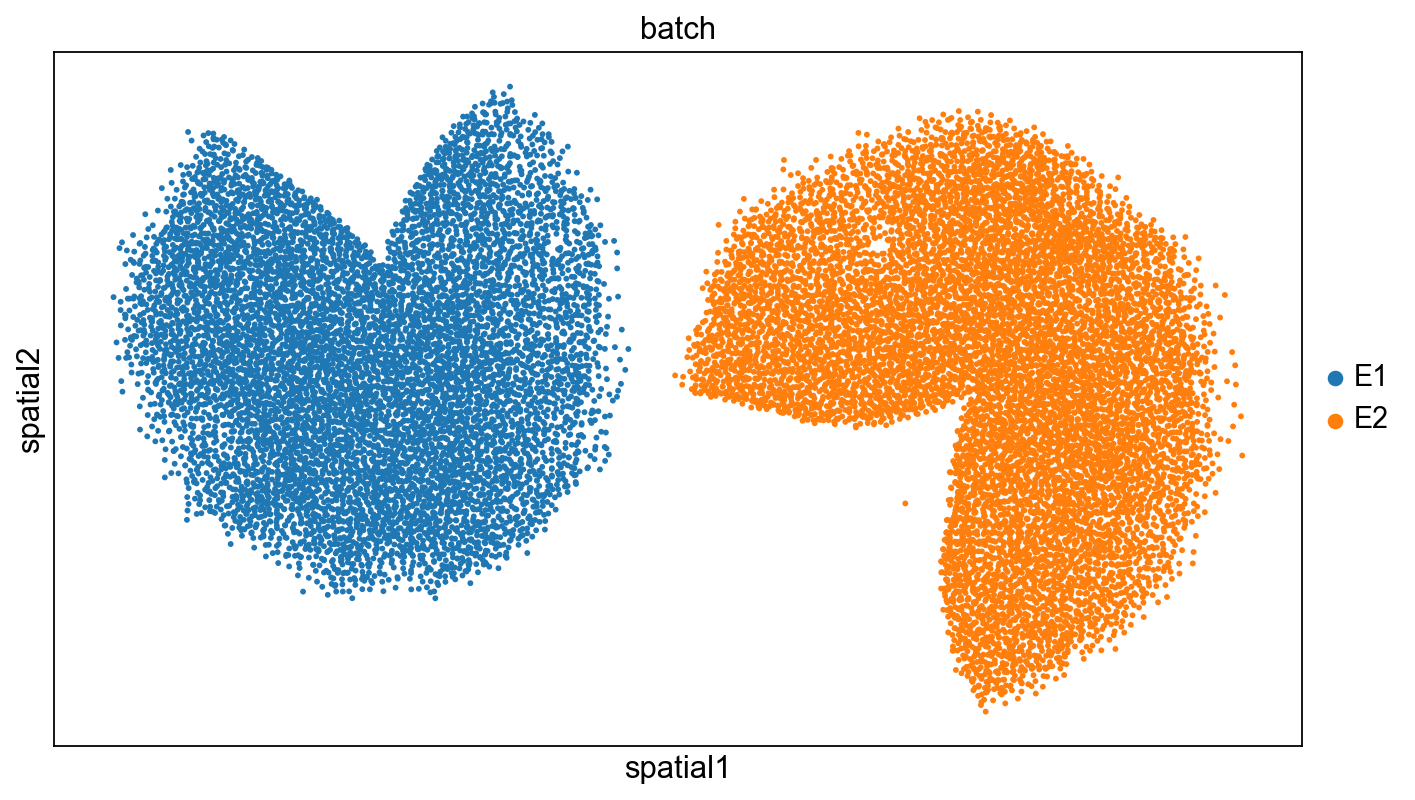

In [20]:
sc.pl.spatial(scdata, color='batch', spot_size=10)

C:\Users\wan0000\AppData\Roaming\Python\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\wan0000\AppData\Roaming\Python\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\wan0000\AppData\Roaming\Python\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.ma

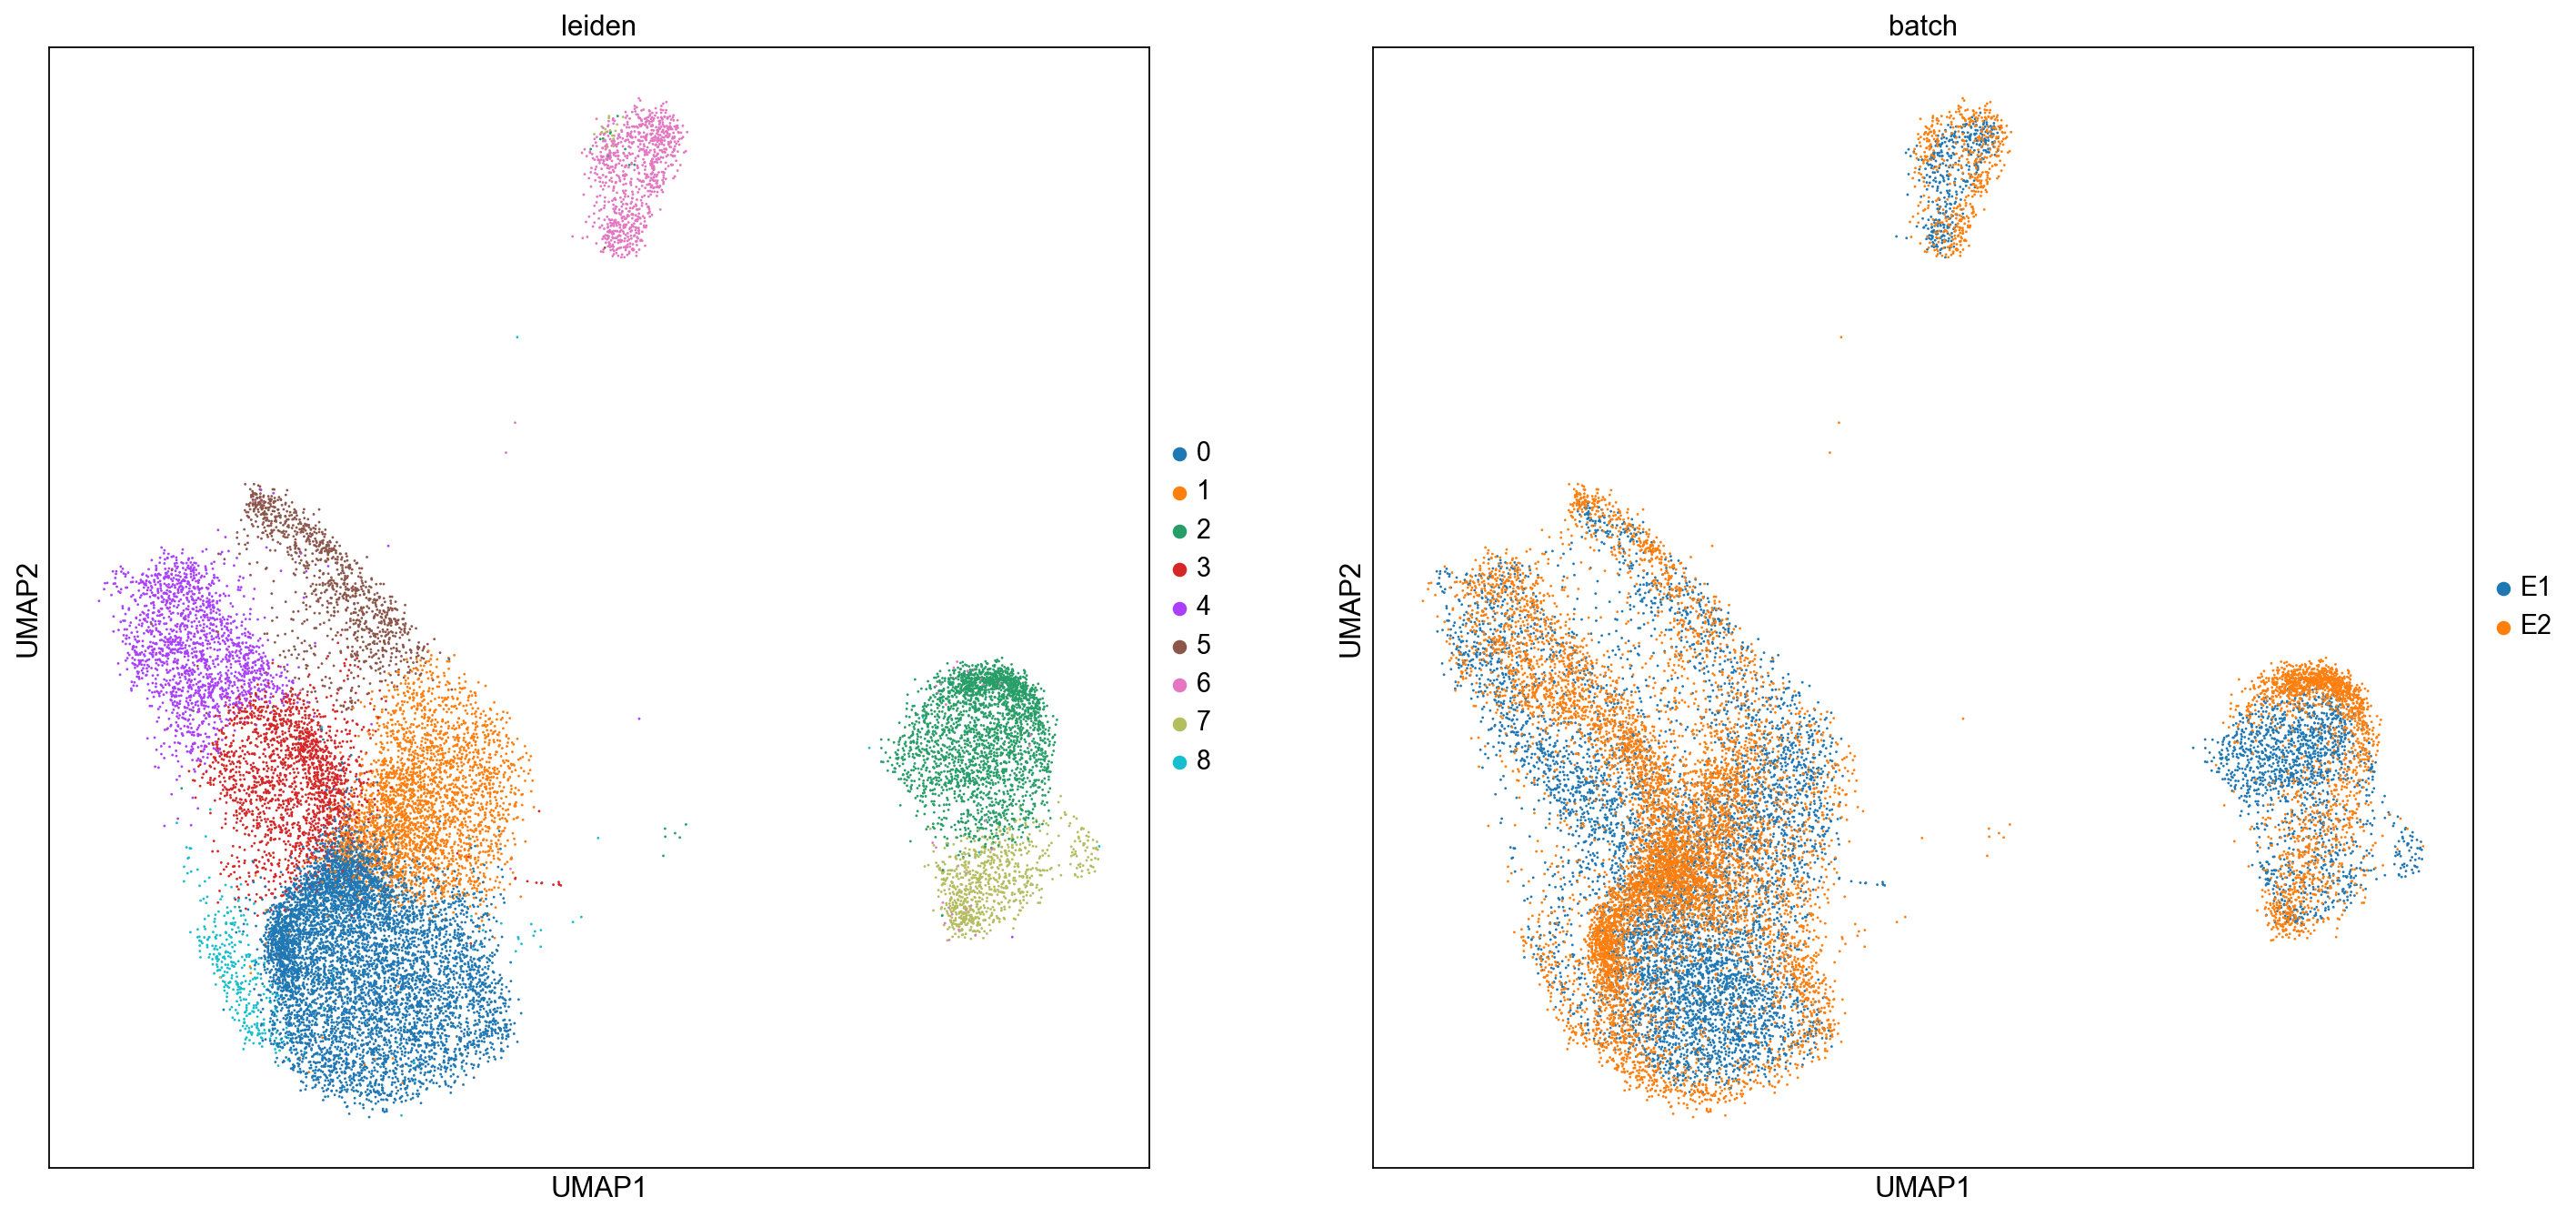

In [21]:
sc.pl.umap(scdata, color=['leiden','batch'])

In [22]:
volume = np.array(scdata.obs['cellvol'])
scdata.X = scdata.obsm['X_ct']/volume[:,np.newaxis]*np.median(volume)
scdata.obsm["X_raw"] = scdata.X.copy()

In [23]:
print('# cells in E1:', np.sum(scdata.obs['batch']=='E1'))
print('# cells in E2:', np.sum(scdata.obs['batch']=='E2'))

# cells in E1: 8547
# cells in E2: 10225


C:\Users\wan0000\AppData\Roaming\Python\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


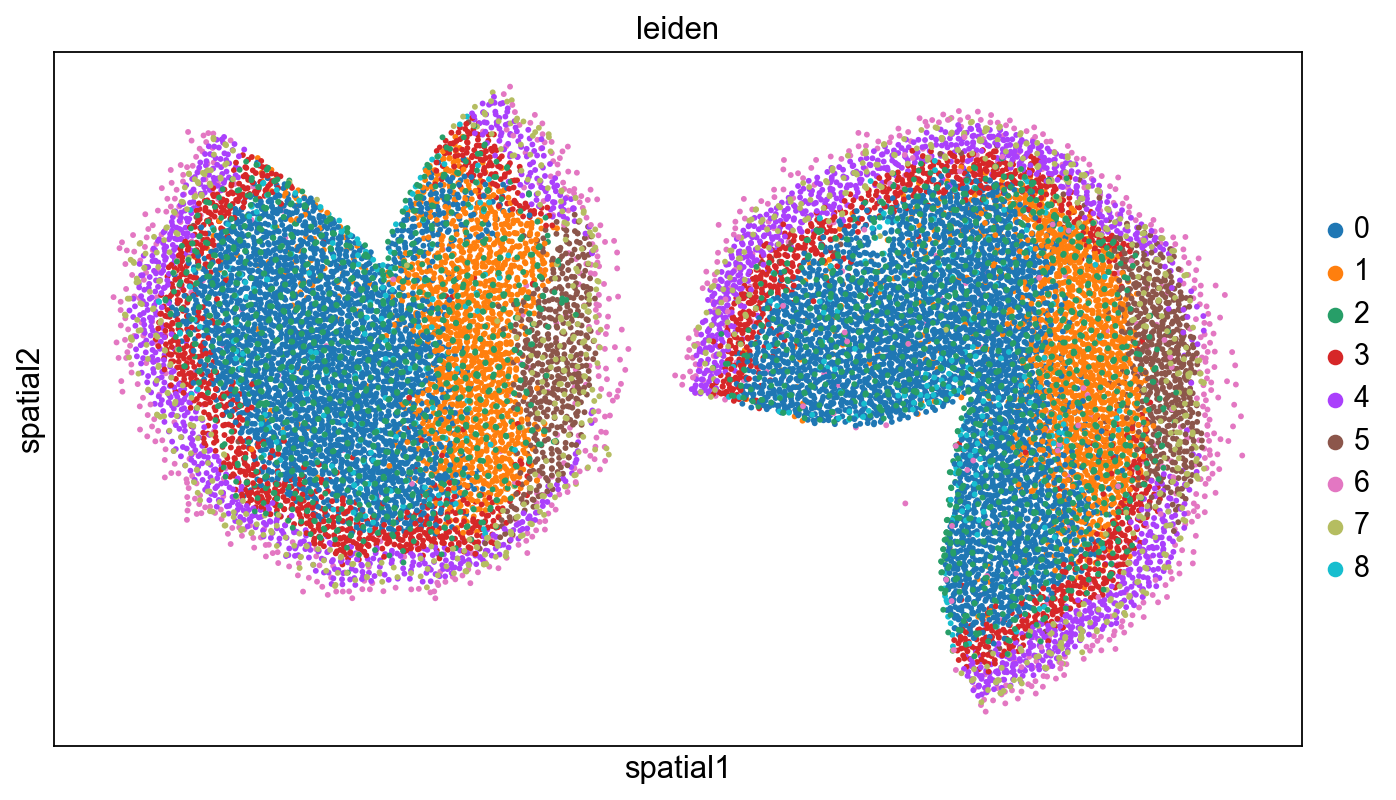

In [24]:
sc.pl.spatial(scdata, color='leiden', spot_size=10)

In [24]:
viewer = visualize_leiden_napari(scdata)

E:\Anaconda3\envs\scanpy_env\lib\site-packages\numpy\core\numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
E:\Anaconda3\envs\scanpy_env\lib\site-packages\numpy\core\numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
E:\Anaconda3\envs\scanpy_env\lib\site-packages\numpy\core\numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
E:\Anaconda3\envs\scanpy_env\lib\site-packages\numpy\core\numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
E:\Anaconda3\envs\scanpy_env\lib\site-pa

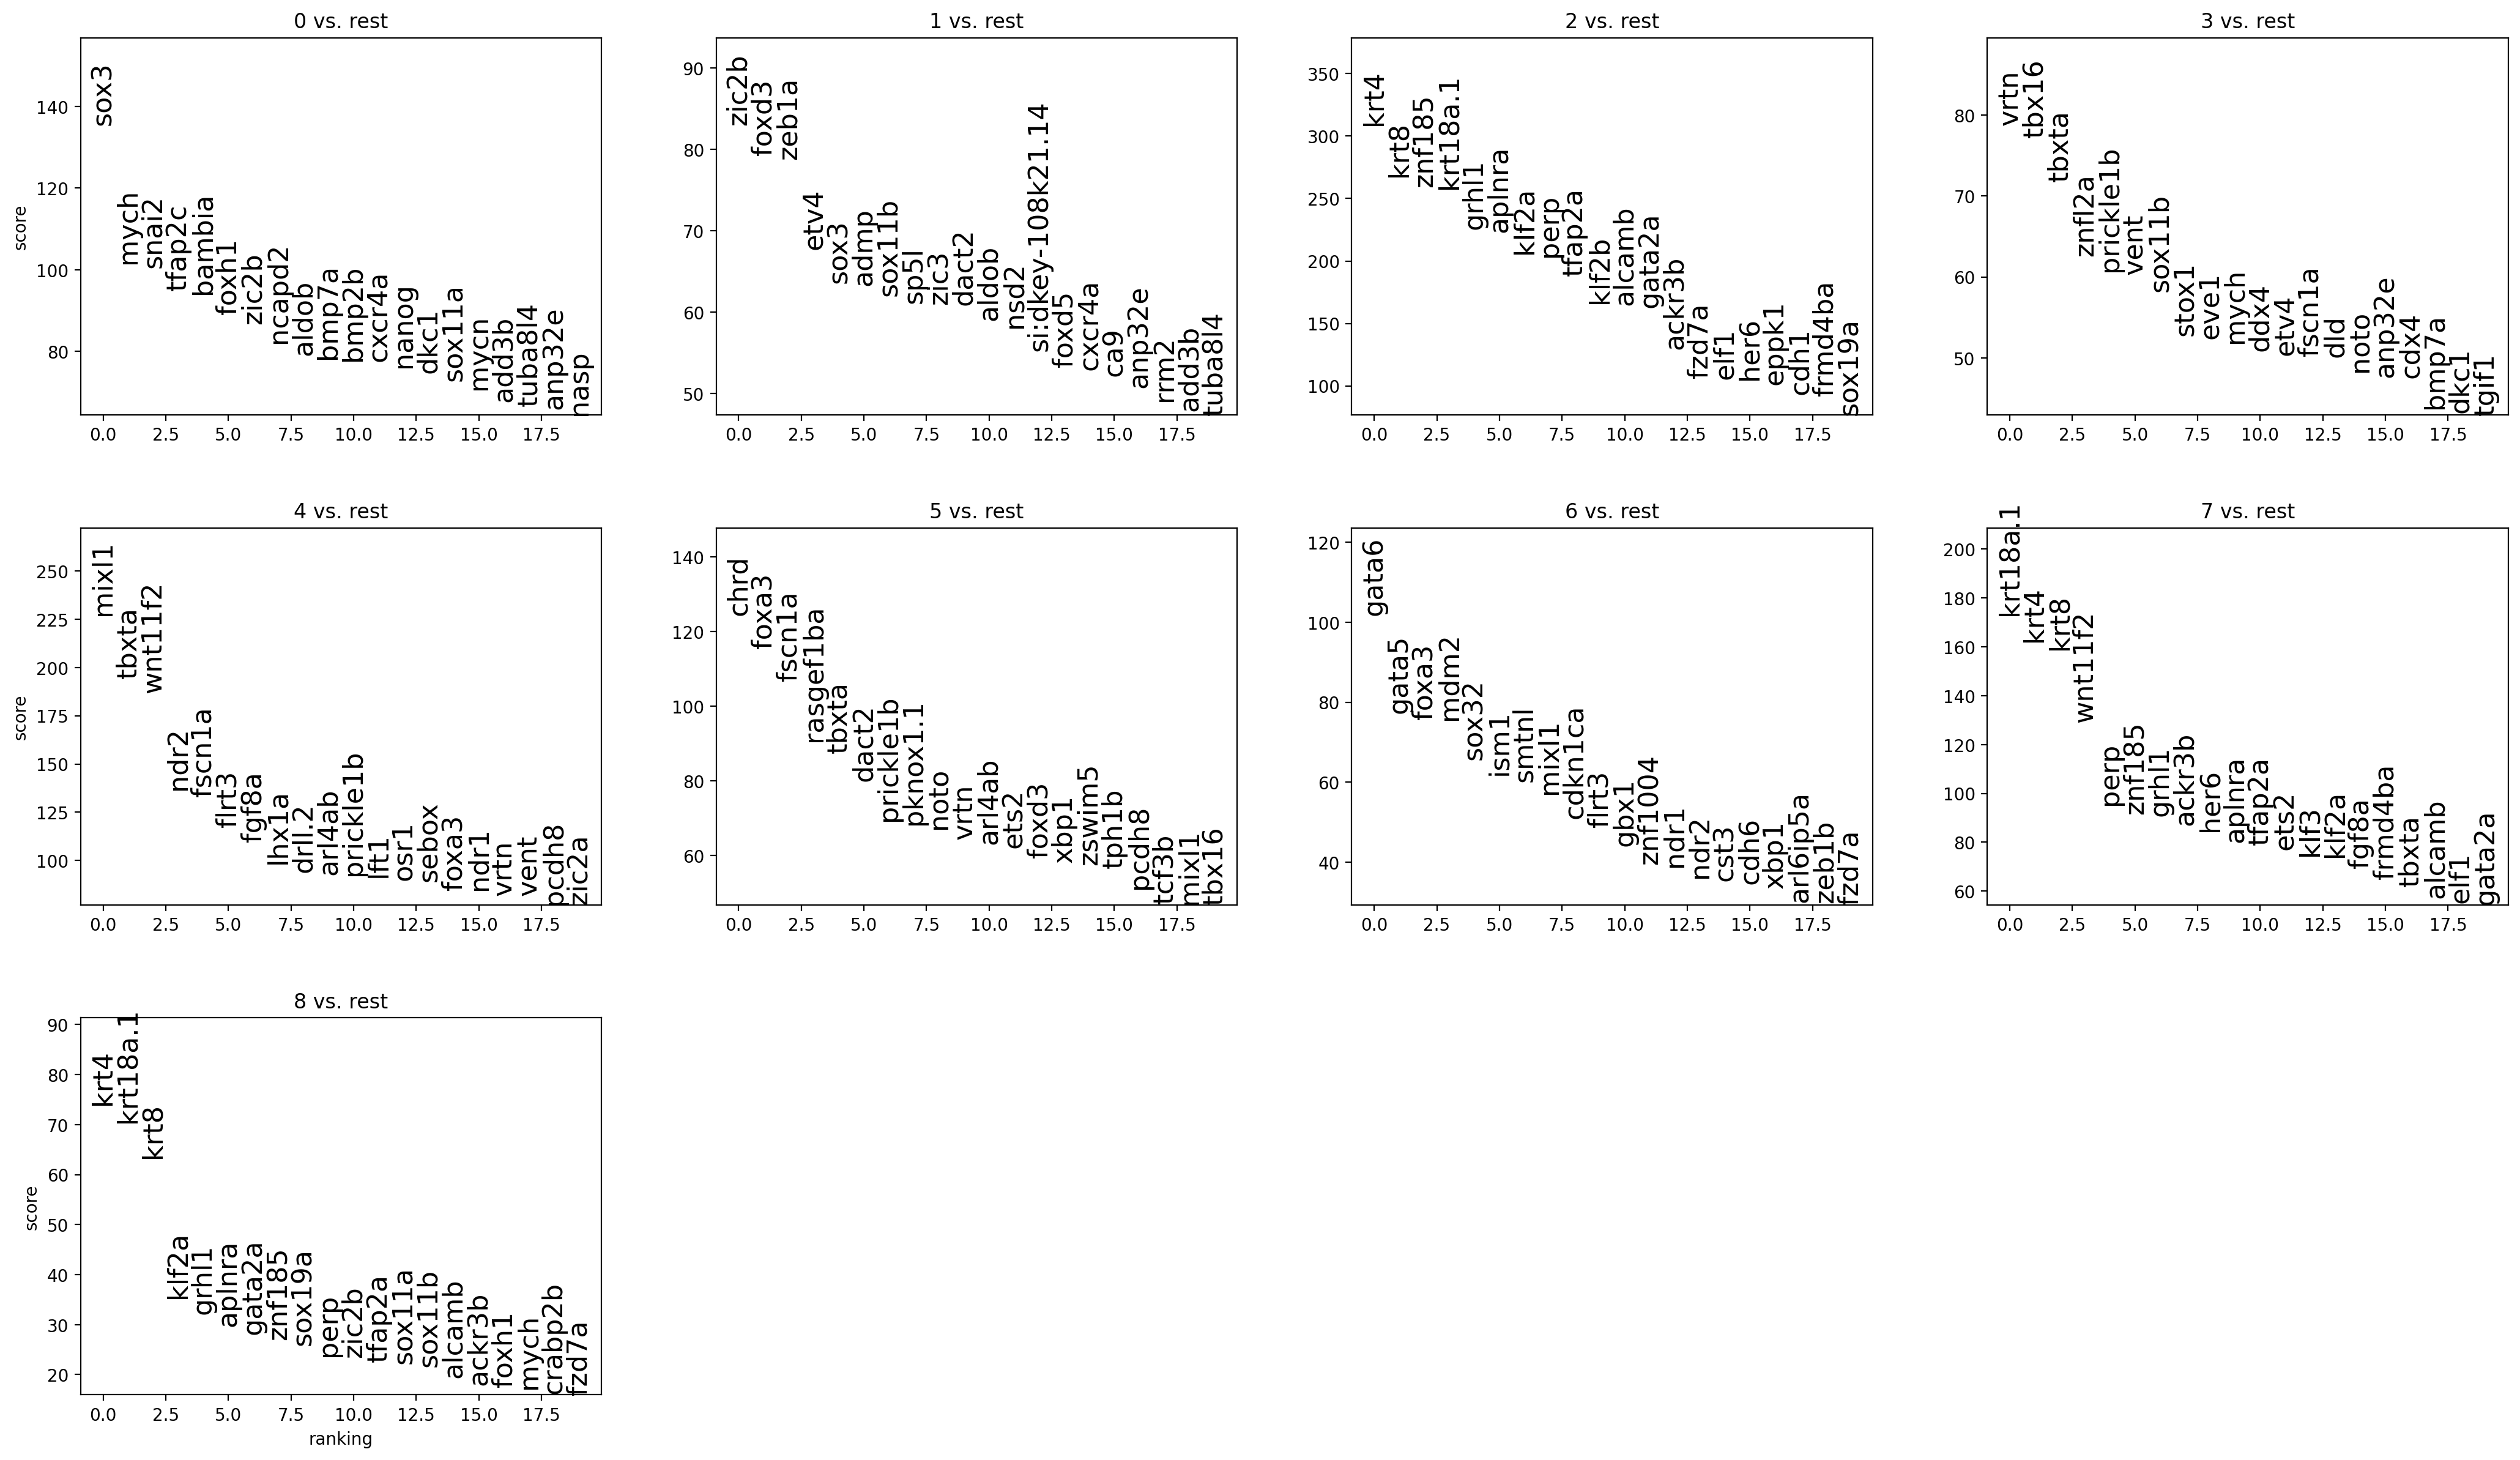

In [25]:
sc.pp.log1p(scdata)
sc.tl.rank_genes_groups(scdata, "leiden", method="t-test")
plt.style.use('default')
sc.pl.rank_genes_groups(scdata, n_genes=20, sharey=False, fontsize=16)

In [80]:
# Write out clusters as segmentation mask
eid = 'E2'
import tifffile
unif_mask = tifffile.imread(raw_dir[eid] + os.sep + stage_id + '_unif_mask_ds4.tif')

In [81]:
dict_cell_leiden = dict(zip(scdata[scdata.obs['batch']==eid].obs['cell_id'], scdata[scdata.obs['batch']==eid].obs['leiden'].astype(np.int16) + 1))
unif_mask_leiden = np.vectorize(dict_cell_leiden.get)(unif_mask, 0)

In [82]:
tifffile.imwrite(raw_dir[eid] + os.sep + stage_id + '_leiden' + str(leiden_res) + '_mask_ds4.tif', unif_mask_leiden.astype(np.int16))

In [83]:
v1 = napari.Viewer()
resc=4
mem_img = tifffile.imread(raw_dir[eid]  + os.sep + stage_id + '_mem_stitched_ds' + str(resc) +'.tif')
v1.add_image(mem_img, name='mem_stitched')
cmap = ['m', 'b', 'r', 'y', 'g', 'c', 'w']
#v1.add_labels(unif_mask_leiden.astype(int), name = 'leiden')
for ic, c in enumerate(np.arange(1, np.max(unif_mask_leiden)+1)):
    v1.add_labels(unif_mask_leiden==c.astype(int), name = 'leiden_'+str(c-1), color={1:cmap[ic % len(cmap)]})

In [84]:
img_dapi = tifffile.imread(raw_dir[eid]  + os.sep + stage_id + '_dapi_stitched_ds4.tif')
v1.add_image(img_dapi)

<Image layer 'img_dapi' at 0x1de03520e20>

In [27]:
from scipy.stats import ranksums
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
plt.style.use('default')
def plot_volcano(scdata, plot_group, control_group='rest', group_id='leiden', pval_thres=10e-100, logFC_thres=1):
    scdata.X = scdata.obsm['X_raw'].copy()
    sc.pp.log1p(scdata)
    sc.tl.rank_genes_groups(scdata, groupby=group_id, groups=[plot_group], method='wilcoxon', reference=control_group)
    logFC = scdata.uns['rank_genes_groups']['logfoldchanges'][plot_group]
    pvals = scdata.uns['rank_genes_groups']['pvals'][plot_group]
    gene_names = scdata.uns['rank_genes_groups']['names'][plot_group]

    pvals = np.maximum(pvals, 10e-300)

    is_significant = (pvals<pval_thres) & (np.abs(logFC)>logFC_thres)

    
    plt.scatter(logFC, -np.log10(pvals), 1, is_significant, cmap='bwr')
    plt.xlabel('log2FC')
    plt.ylabel('-log10(pval)')
    plt.title(group_id + ' ' +  control_group + ' vs. ' + plot_group)

    for i, (x, y, significant, gene) in enumerate(zip(logFC, -np.log10(pvals), is_significant, gene_names)):
        if significant:
            plt.text(x, y, gene, fontsize=8)

    return logFC, pvals

E:\Anaconda3\envs\scanpy_env\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


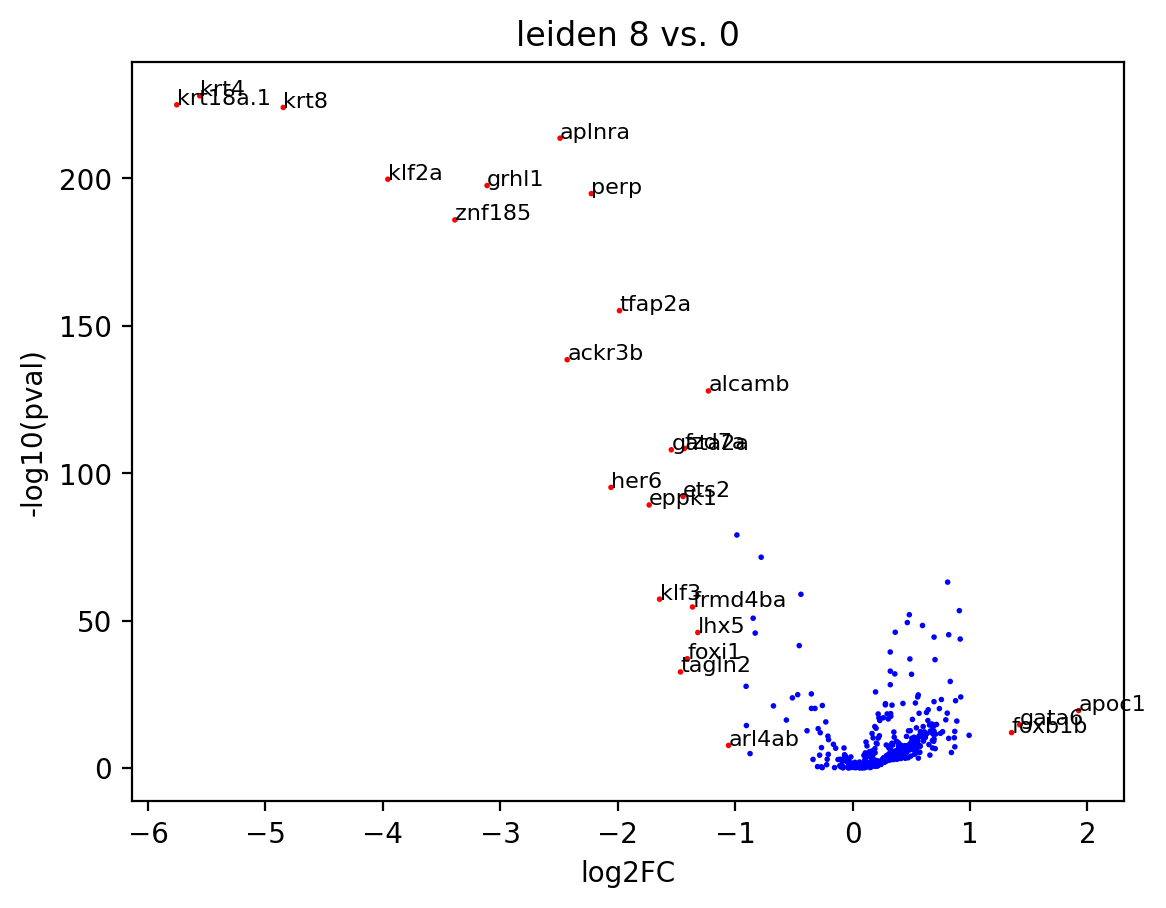

In [28]:
logFC, pval = plot_volcano(scdata, plot_group='0', control_group='8', group_id='leiden', pval_thres=10e-5)

E:\Anaconda3\envs\scanpy_env\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


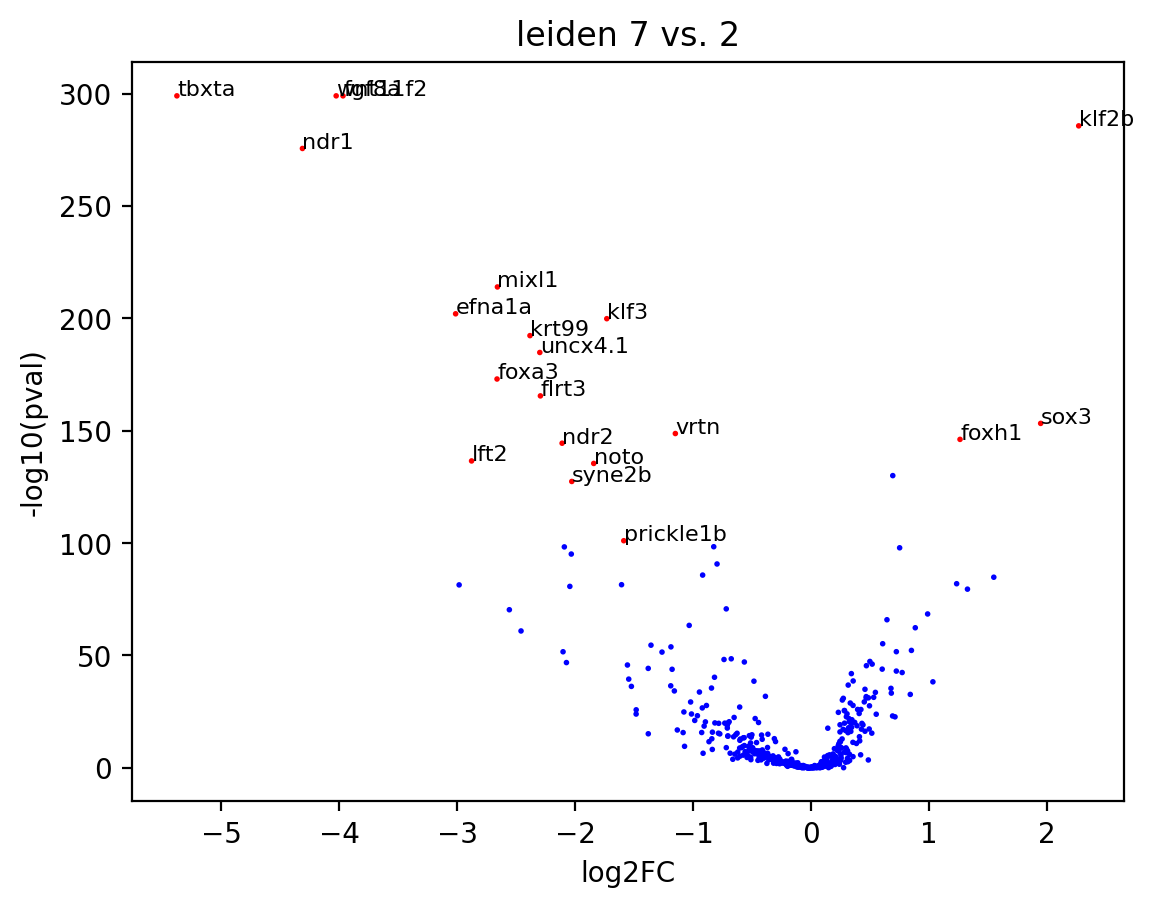

In [29]:
logFC, pval = plot_volcano(scdata, plot_group='2', control_group='7', group_id='leiden', pval_thres=10e-100)

In [32]:
anno = pd.read_excel(res_dir + os.sep +  prefix + '_' + stage_id + '_cluster_annotation.xlsx')

In [34]:
annotation = ['clusters', 'type']
columns = ['clusters-annotated', 'Type']

for feat, col in zip(annotation, columns):
    dict_cells = dict(zip(anno['leiden-1'], anno[col]))
    scdata.obs[feat] = np.vectorize(dict_cells.get)(scdata.obs['leiden'].astype(int))

C:\Users\wan0000\AppData\Roaming\Python\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\wan0000\AppData\Roaming\Python\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\wan0000\AppData\Roaming\Python\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\wan0000\AppData\Roaming\Python\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cma

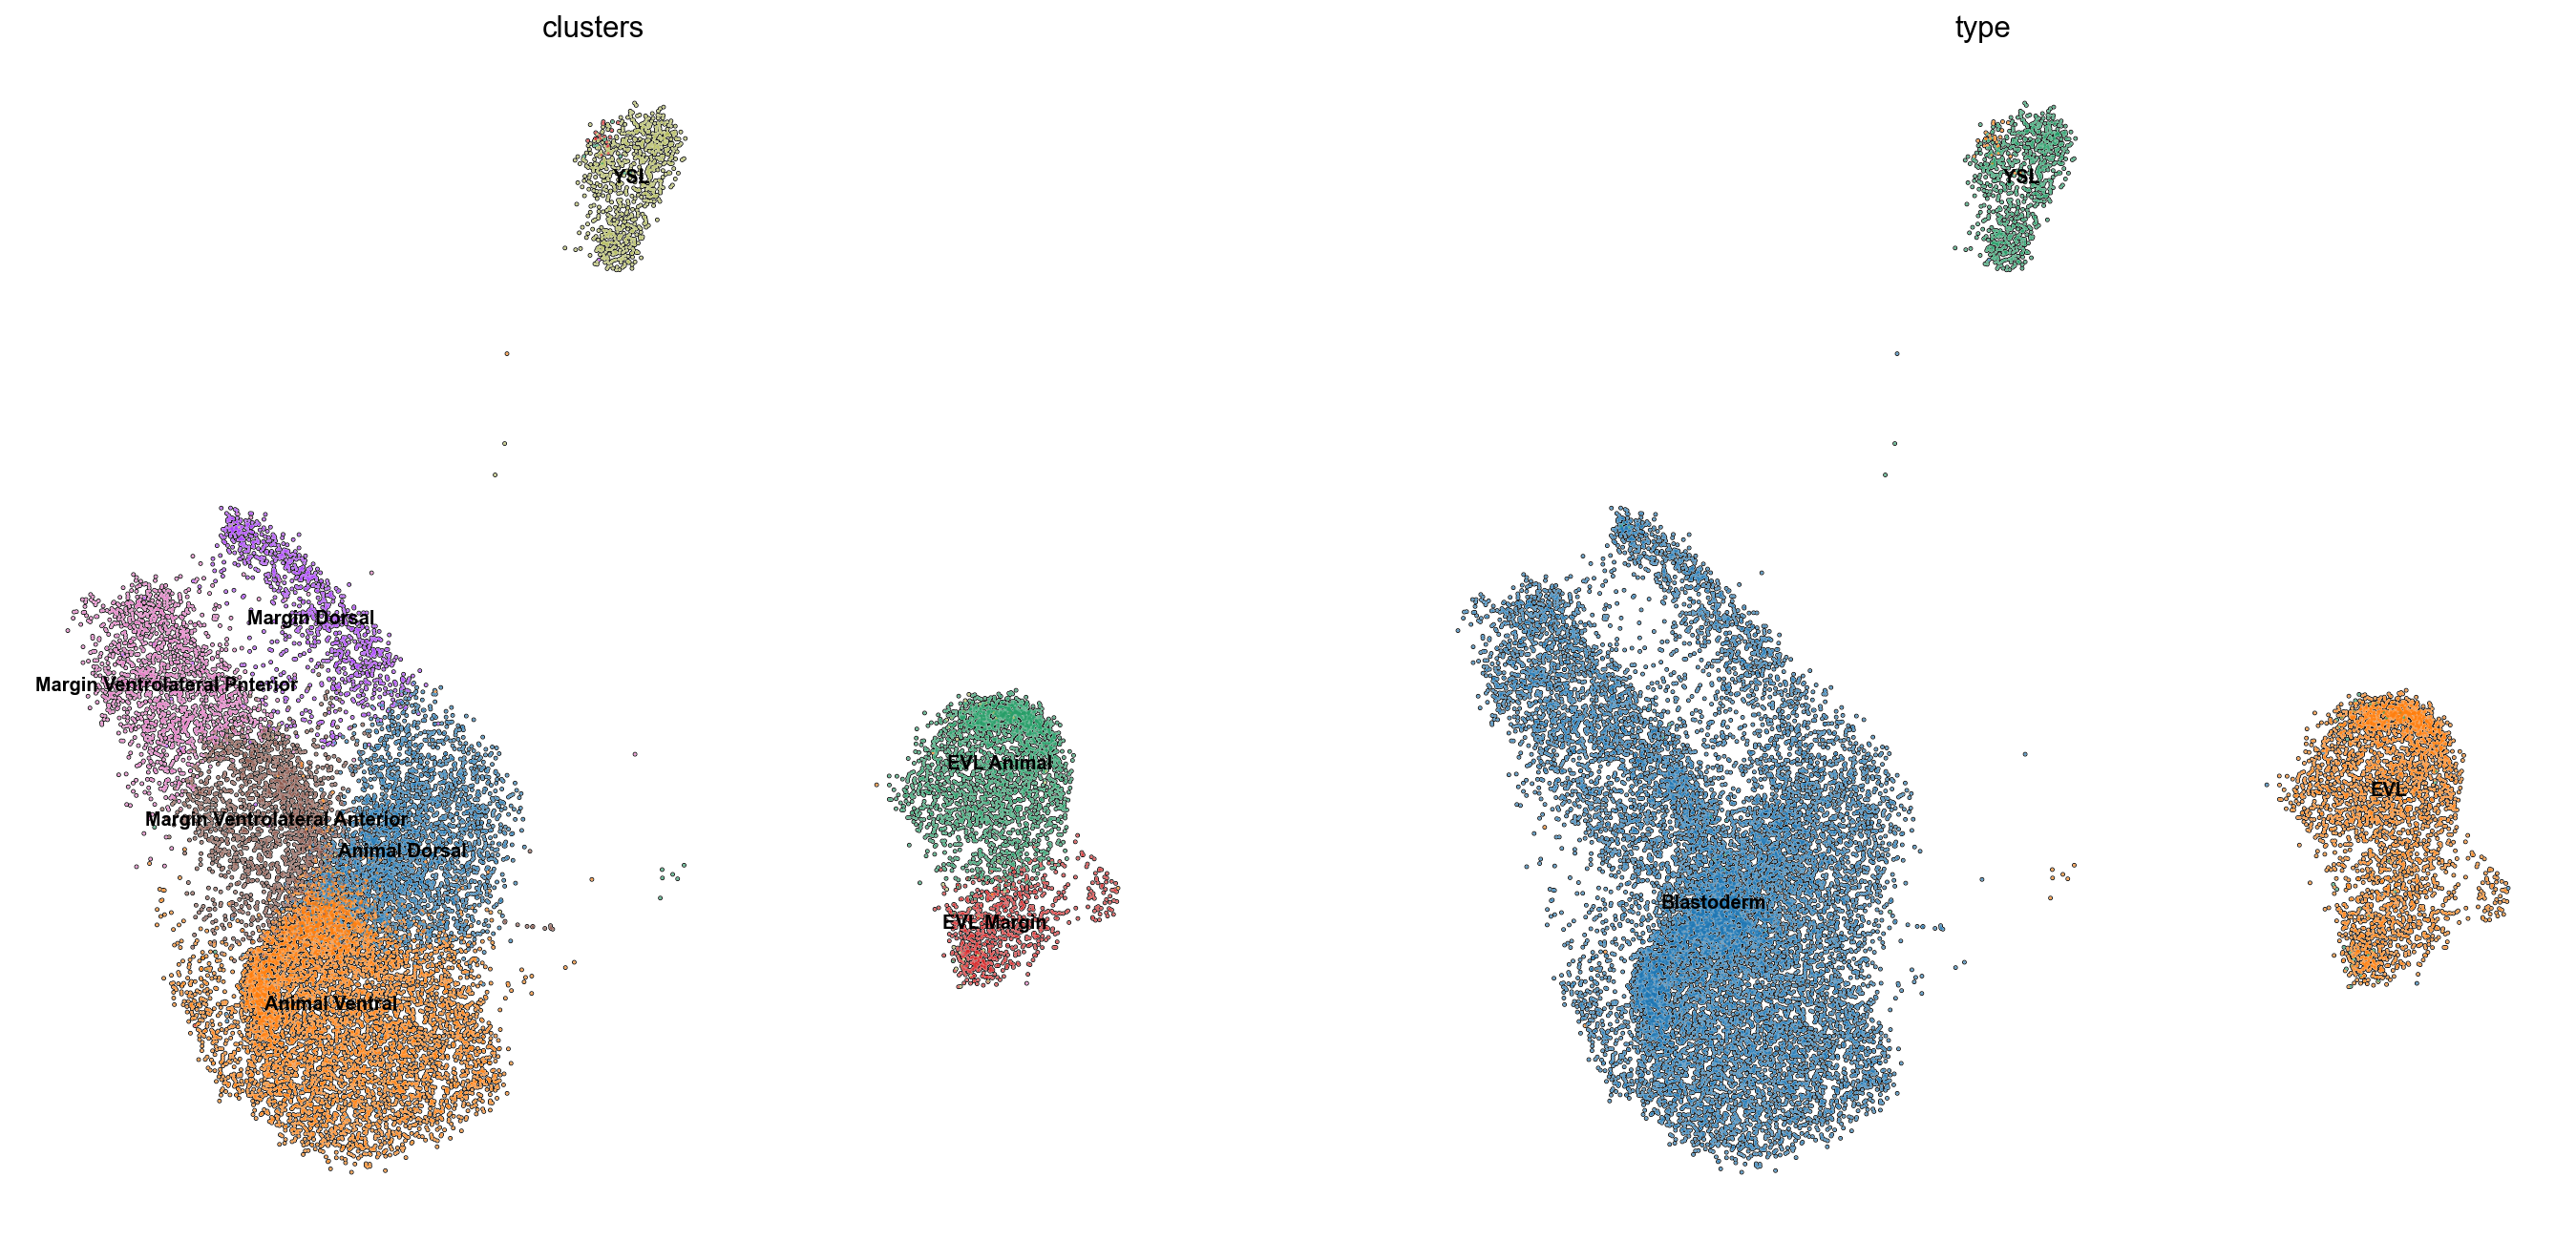

In [37]:
plt.style.use('default')
sc.set_figure_params(figsize=(10,10))
sc.pl.umap(
    scdata,
    color=['clusters', 'type'],
    legend_loc="on data",
    add_outline=True,
    frameon=False,
    legend_fontsize=9
)

In [5]:
scdata.X = scdata.obsm['X_raw'].copy()

In [6]:
sc.write(res_dir + os.sep + prefix + '_' + stage_id + '_scdata_all.h5ad', scdata)

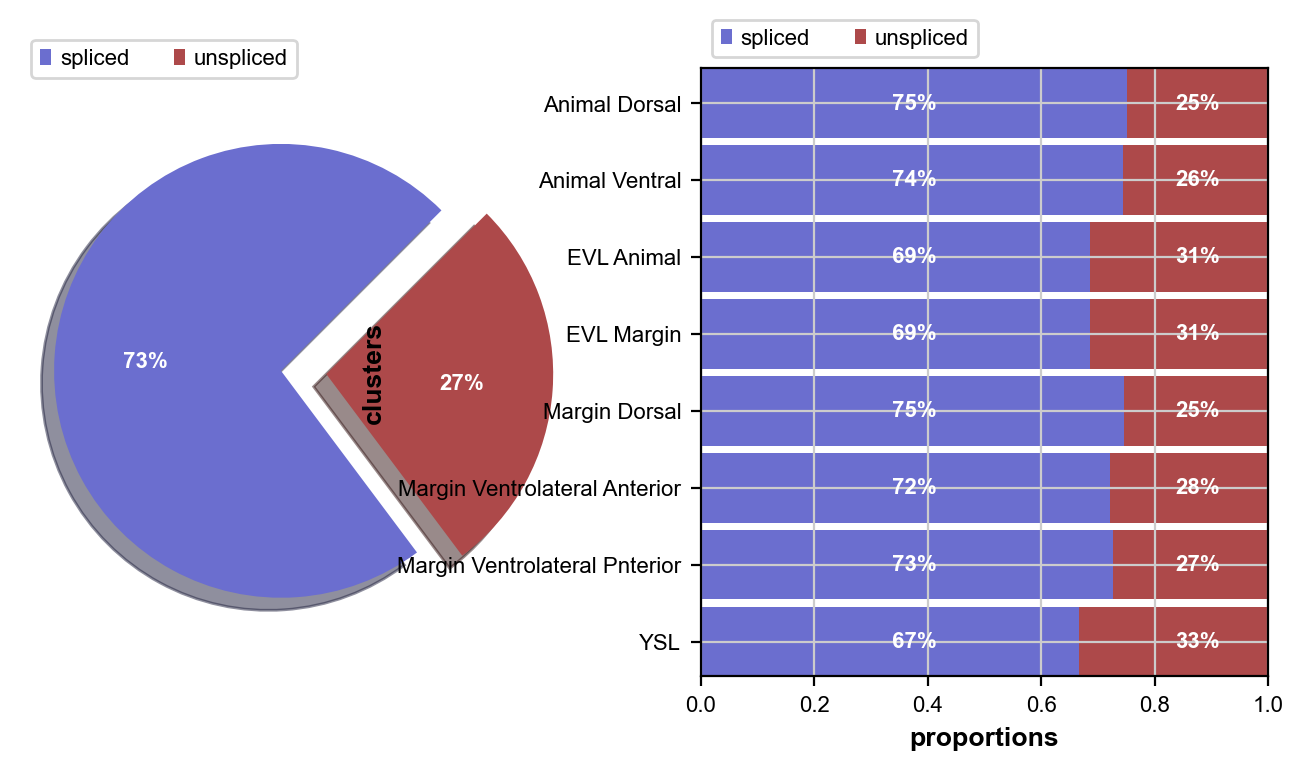

In [41]:
import scvelo as scv
scv.pl.proportions(scdata, figsize=(8, 4), groupby='clusters')

## Plot genes - restart the kernel first

In [2]:
scdata = sc.read_h5ad(res_dir + os.sep + prefix + '_' + stage_id + '_scdata_all.h5ad')

In [3]:
save_dir = fig_dir + os.sep + prefix + '_' + stage_id
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

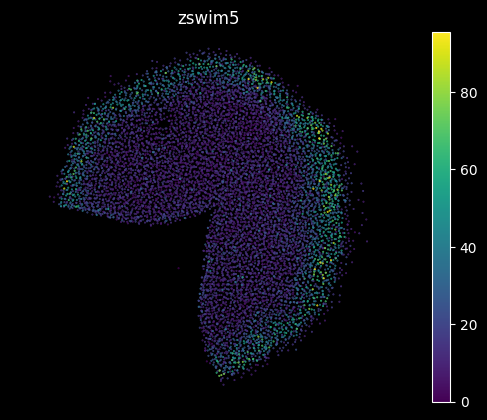

In [7]:
# Save gene expression dat
from tqdm import tqdm
import matplotlib.pyplot as plt
genes = list(scdata.var_names.astype(str))

for eid in ['E1', 'E2']:
    scdata_use = scdata[scdata.obs['batch']==eid]
    plt.style.use('dark_background')
    for ig, gn in enumerate(genes):  # Use this to set figure params like size and dpi
    #for ig, gn in enumerate(genes[:1]):   
        fl = os.path.join(save_dir, gn.replace(':', '-') + '_'+ eid + '.png')
        
        #if os.path.exists(fl):
        #    continue
        
        plt.clf()  # Clear the current figure
        
        order = np.argsort(scdata_use.X[:, ig])
        plt.scatter(scdata_use.obsm['spatial'][order, 0], -scdata_use.obsm['spatial'][order, 1], s=0.2, c=scdata_use.X[order, ig], vmin=0, vmax=np.percentile(scdata_use.X[:, ig], 99.9))
        plt.title(gn)
        plt.axis('equal')
        plt.axis('off')
        plt.colorbar()

        plt.savefig(fl, dpi=300)

In [9]:
sphere_dir = res_dir + os.sep + '3D_Visualization'
sphere_ref = {'E1': sphere_dir + os.sep + '23-08-29__scdata_50p_annotated__3dV7.h5ad', 'E2': sphere_dir + os.sep + '23-07-28__scdata_50p_annotated__3dV7.h5ad'}

In [22]:
scdata.obs['phi'] = np.zeros([scdata.shape[0], 1])
scdata.obs['theta'] = np.zeros([scdata.shape[0], 1])
scdata.obsm['global_sphere'] = np.zeros([scdata.shape[0], 3])

In [28]:
for eid in ['E1', 'E2']:
    kp = scdata.obs['batch']==eid
   
    scdata_sphere = sc.read_h5ad(sphere_ref[eid])
    scdata_sphere.obs_names = eid + '_' + scdata_sphere.obs_names
    cn = scdata[kp].obs_names

    X_ = scdata_sphere.obsm['global_sphere']# x,y,z sphere
    re = np.mean(np.linalg.norm(X_,axis=-1))
    X__ = X_/np.linalg.norm(X_,axis=-1)[...,np.newaxis] ### normalized vectors 
    
    costh = np.clip(np.squeeze(np.dot(X__,np.array([[0,1,0]]).T)),-1,1)
    theta = np.arccos(costh)/np.pi*180 ### Theta in angles.
    phi = np.arctan2(X__[:,0],X__[:,-1])/np.pi*180 ### phi in angles
    
    dorsal_phi = np.mean(phi[scdata_sphere.obs['clusters']=='dorsal margin'])
    new_phi = phi - dorsal_phi
    new_phi[new_phi<-180] += 360
    new_phi[new_phi>180] -= 360
    scdata_sphere.obs['phi'] = new_phi
    scdata_sphere.obs['theta'] = theta

    scdata.obsm['global_sphere'][kp] = scdata_sphere[scdata[kp].obs_names].obsm['global_sphere'].copy()
    scdata.obs['phi'][kp] = scdata_sphere[scdata[kp].obs_names].obs['phi'].copy()
    scdata.obs['theta'][kp] = scdata_sphere[scdata[kp].obs_names].obs['theta'].copy()

C:\Users\wan0000\AppData\Local\Temp\ipykernel_18380\1861807459.py:24: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  scdata.obs['phi'][kp] = scdata_sphere[scdata[kp].obs_names].obs['phi'].copy()
C:\Users\wan0000\AppData\Local\Temp\ipykernel_1

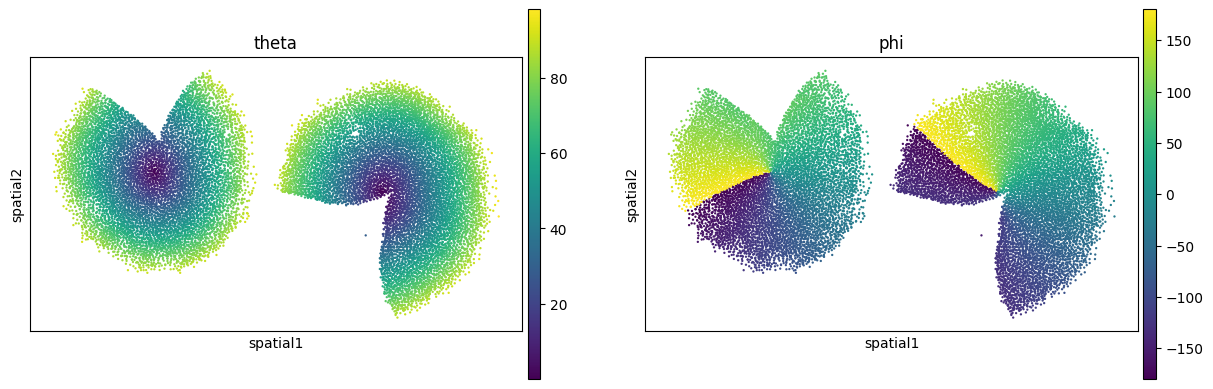

In [32]:
import matplotlib.pyplot as plt
plt.style.use('default')
sc.pl.spatial(scdata, color=['theta', 'phi'], spot_size=10)

In [33]:
sc.write(res_dir + os.sep + prefix + '_' + stage_id + '_scdata_all.h5ad', scdata)

C:\Users\wan0000\AppData\Roaming\Python\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


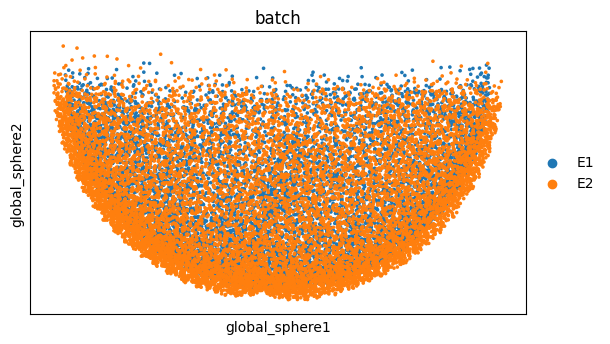

In [34]:
sc.pl.spatial(scdata, color=['batch'], basis='global_sphere', spot_size=50)

C:\Users\wan0000\AppData\Roaming\Python\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


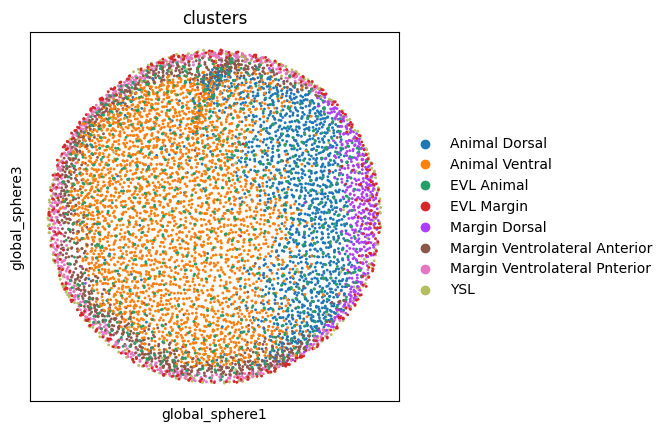

In [38]:
sc.pl.spatial(scdata[scdata.obs['batch']=='E1'], color='clusters', basis='global_sphere', spot_size=50, dimensions=(0, 2))

C:\Users\wan0000\AppData\Roaming\Python\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


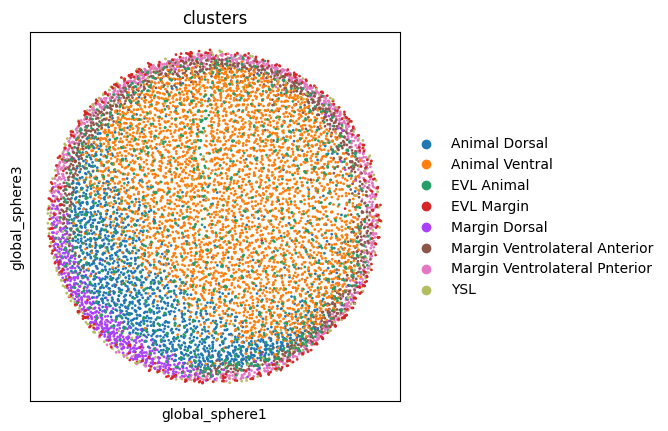

In [39]:
sc.pl.spatial(scdata[scdata.obs['batch']=='E2'], color='clusters', basis='global_sphere', spot_size=50, dimensions=(0, 2))